# Image Restoration

The captured image is normally affected by noise from several sources. These sources are e.g. noise arising from electrical sensors, channel errors, graininess, etc. noise arising from sensors or channels is in the form of isolated variations of pixel values that are not correlated with each other and that are visible in the image as significantly different values of adjacent pixels.

In the following figure, the process of noise generation and image degradation, e.g. by blurring, is visualized with a block diagram.

![diagram 1](https://cw.fel.cvut.cz/wiki/_media/courses/b4m33dzo/labs/im_degradation.jpg)

in reality the image is degraded by both noise and degradation function at the same time, for simplicity we will consider only noise.

## Noise models

There are many models of noise, in this lesson we will consider the following four:

### Noise with uniform distribution
The noise with uniform distribution is generated from the range of $low$ and $high$ according to the rule:

$
\begin{equation}
p(z) = \begin{cases}
\frac{1}{high-low}, & \text{if } low \leq z \leq high \\
0, & \text{otherwise} \\
\end{cases}
\end{equation}
$

where $p(z)$ is the probability that the pixel takes on the noise value $z$.

### The Gaussian noise

It is generated using the normal distribution as defined by the rule:

$
\begin{equation}
p(z) = \frac{1}{ \sqrt{2\pi \sigma^2}} \; \exp \left( - \frac{(z - \mu)^2}{2\sigma^2} \right),
\end{equation}
$

where $\mu$ is the mean and $\sigma$ is the standard deviation.

### Salt&Peper

Noise in the form of pulses often caused by A/D converter error or transmission error. It causes a certain number of pixels to have 0 or maximum value.

The probability of a pixel having intensity $z$ is given by

$
\begin{equation}
p(z) = \begin{cases}
pPepper, & \text{for } z = 0 \text{ (pepper)} \\
pSalt, & \text{for } z = 2^n - 1 \text{ (salt)} \\
1-(pPepper+pSalt), & \text{for } 0 < z < 2^n - 1, \\
\end{cases}
\end{equation}
$

where $n$ is the number of bits in which the pixel value is encoded (8). To generate this filter, use the function to generate random numbers from a uniform distribution.


### Noise with exponential distribution

In the case of exponential noise, the likelihood is generated by the rule:

$
\begin{equation}
p(z) = \begin{cases}
0, & z < 0 \\
\lambda \exp(-\lambda z), & z \geq \lambda \\
\end{cases}
\end{equation}
$


In [6]:
import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt

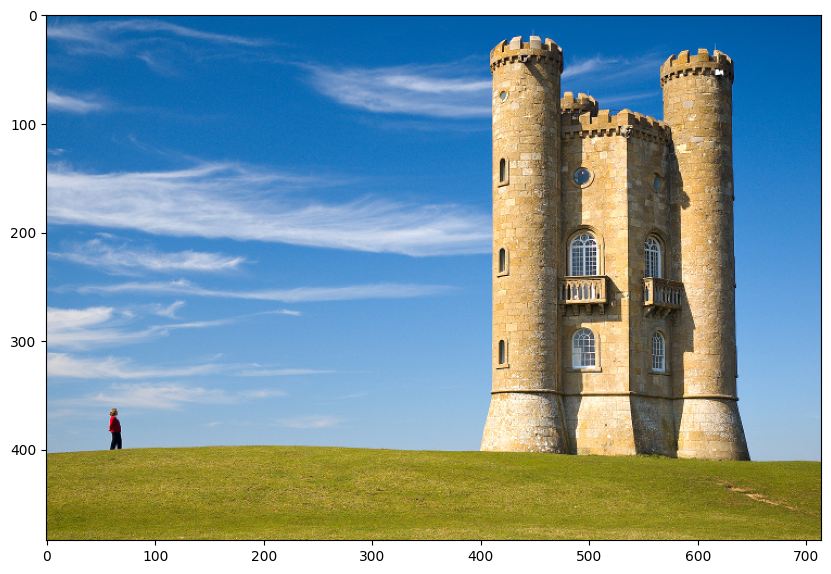

In [7]:
img = skimage.io.imread('https://github.com/CVUT-FS-12110/Machine-Perception-and-Image-Analysis/blob/master/src/lectures/08_image_restoration/data/tower.jpg?raw=true')
fig = plt.figure(figsize= (10,10))
plt.imshow(img);

In [224]:
def uniform_noise(img, low=-0.1, high=0.1):
    """
    Application of uniform noise to the image in the range of low to high
    
    Parameters
    ----------
    img : ndarray
        Image loaded with function from opencv or skimage
    low : float
        minimum value to generate uniform noise
    high : float
        maximum value for generating uniform noise
    
    Returns
    ----------
    tuple
        noise image, noise image, noise value vector
    """

    img_noise = img.copy().flatten()
    
    noise_rnd = np.random.uniform(low, high, img_noise.shape) 

    mask_add = np.zeros(img_noise.shape, np.uint8)
    mask_sub = np.zeros(img_noise.shape, np.uint8)
    
    mask_add[np.where(noise_rnd >= 0)] = 1
    mask_sub[np.where(noise_rnd < 0)] = 1
   
    img_noise[mask_add.astype(bool)] = cv2.add(img_noise, (noise_rnd * 255).astype(np.uint8), mask=mask_add).flatten()[mask_add.astype(bool)]
    img_noise[mask_sub.astype(bool)] = cv2.subtract(img_noise, np.abs((noise_rnd * 255)).astype(np.uint8), mask=mask_sub).flatten()[mask_sub.astype(bool)]

    noise = noise_rnd.reshape(img.shape)+0.5

    return img_noise.reshape(img.shape), noise, (noise_rnd*255).flatten()

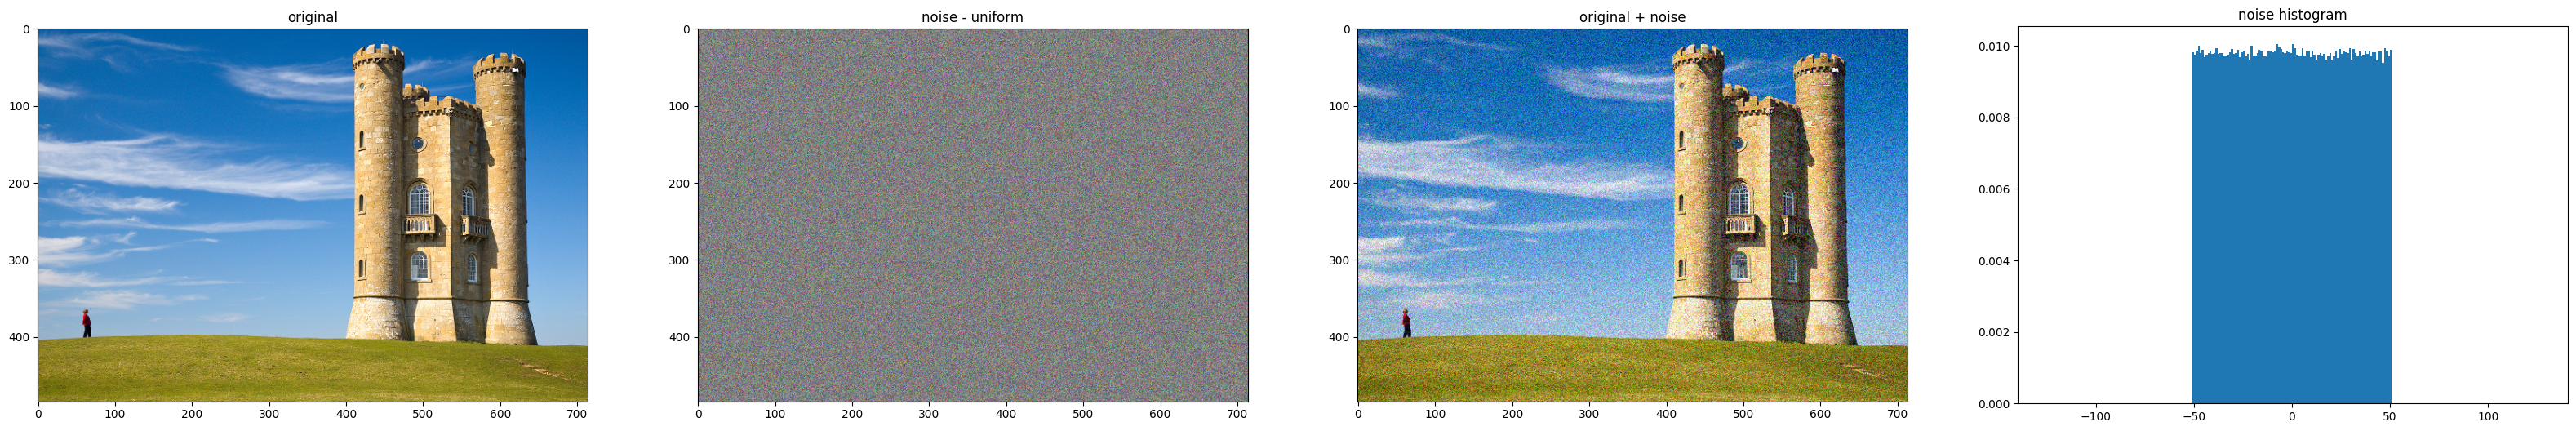

In [225]:
img_noise, noise, noise_raw = uniform_noise(img, -0.2, 0.2)
fig = plt.figure(figsize= (40,6))
plt.subplot(141)
plt.imshow(img);
plt.title('original')
plt.subplot(142)
plt.imshow(noise);
plt.title('noise - uniform')
plt.subplot(143)
plt.imshow(img_noise);
plt.title('original + noise')
plt.subplot(144)
plt.hist(noise_raw, density=True, bins=np.linspace(-127, 128, 256));
plt.title('noise histogram');

## Image restoration

To restore a degraded image, you first need to estimate the type of degradation. We will consider only noise. A visualization of the image restoration process using a block diagram is shown in the following figure:

![diagram 2](https://cw.fel.cvut.cz/wiki/_media/courses/b4m33dzo/labs/im_restoration.jpg)

## Noise removal

Noise can be reduced using statistical filters. Here it depends on what kind of noise is present in the image. The filter is applied as a convolution filter corresponding to the given statistical operation. Consider an image $g(s,t)$ where $g$ and $s$ are the coordinates of a pixel in the image. The convolution filter is then $S_{xy}$.

### Median filter
It is suitable for Salt&Peper type noise reduction. The prescription for calculating a new image is

$
\begin{equation}
\hat{f}(x,y) = \underset{(s,t) \in S_{xy}}{\mathrm{median}} \, g(s,t)
\end{equation}
$

### Averaging filter

It is suitable for removing Gaussian noise. The new image is created according to the rule

$
\begin{equation}
\hat{f}(x,y) = \frac{1}{mn}\sum_{(s,t) \in S_{xy}} g(s,t),
\end{equation}
$

where $m$ and $n$ are the dimensions of the convolution filter.

The following [OpenCV2 function](https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html) can be used for the median and averaging filter.

### MIN filter
Corresponds to the morphological erosion.

$
\begin{equation}
\hat{f}(x,y) = \min_{(s,t) \in S_{xy}} g(s,t)
\end{equation}
$

### MAX filter
Corresponds to morphological dilation.

$
\begin{equation}
\hat{f}(x,y) = \max_{(s,t) \in S_{xy}} g(s,t)
\end{equation}
$

For the MIN and MAX filters it is possible to use the [OpenCV2 functions for erosion](https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html) and [dilation](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html)
